# Nearest Earth Object Classification

### By Michael D'Arcy-Evans and Isabel Tilles

## Introduction:
The solar system is a dangerous place. One fear that scientists have is that we will be harmed an objects as it hurtles towards us from space. We spot objects like these coming towards Earth all the time, but how do we know if they are going to devastate us or simply provide a good comet show? We are seeking to solve that issue by creating a reliable classifier to determine whether or not a Near Earth Object (NEO) is hazardous.  
We got our data from the [Nearest Earth Objects Dataset (1910-2024)](\"https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024\"). Based on these instances, we hope to predict whether or not other unseen instances of NEOs will be classified as `is_hazardous`.  
#TODO: What classifier performed the best?

## Imports for Analysis

In [84]:
# some useful mysklearn package import statements and reloads
import importlib


import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation


## Data Analysis

Before cleaning the dataset, this is what it looks like:

This dataset has 338171 instances and 9 attributes
Dataset attribute breakdown:  neo_id is of type <class 'float'> 
 name is of type <class 'str'> 
 absolute_magnitude is of type <class 'float'> 
 estimated_diameter_min is of type <class 'float'> 
 estimated_diameter_max is of type <class 'float'> 
 orbiting_body is of type <class 'str'> 
 relative_velocity is of type <class 'float'> 
 miss_distance is of type <class 'float'> 
 is_hazardous is of type <class 'str'> .
The attribute we are trying to predict is is_hazardous. It can be 2 different classifications: {'True', 'False'}.

There are 295009 instances classified as False
There are 43162 instances classified as True


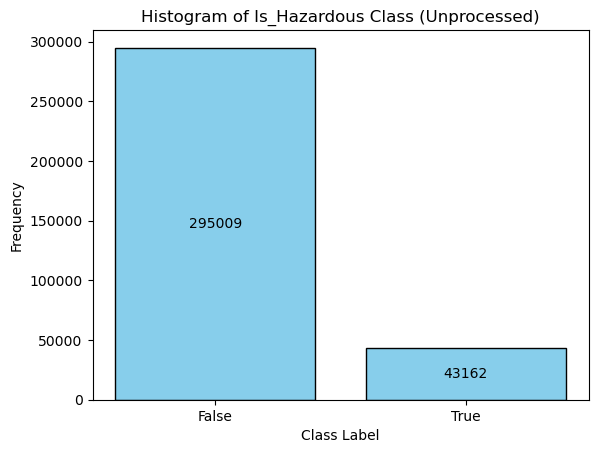

In [85]:
labels = ["True","False"]
space_table = MyPyTable().load_from_file('input_data/space.csv')

space_table.remove_rows_with_missing_values()
myutils.print_dataset_info(space_table)

space_dict = myutils.count_label_occurrences(space_table.get_column("is_hazardous"))
for value in sorted(space_dict.keys()):
    print(f"There are {space_dict[value]} instances classified as {value}")
    pass
myutils.plot_bar_chart(space_dict)

After cleaning the data to keep 1,000 instances of each classification, it looks like this:

This dataset has 2000 instances and 5 attributes
Dataset attribute breakdown:  min_labels is of type <class 'int'> 
 max_labels is of type <class 'int'> 
 velocity_labels is of type <class 'int'> 
 miss_labels is of type <class 'int'> 
 is_hazardous is of type <class 'str'> .
The attribute we are trying to predict is is_hazardous. It can be 2 different classifications: {'True', 'False'}.



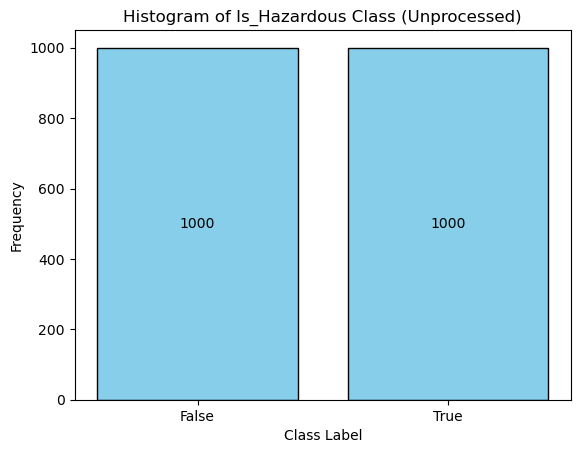

In [86]:
discretized_label_dict = myutils.preprocess_table(space_table)
y_true = space_table.get_column(space_table.column_names.index("is_hazardous"))  
X_train = [row[:space_table.column_names.index("is_hazardous")] + row[space_table.column_names.index("is_hazardous") + 1:] for row in space_table.data]
clean_data = [value + [y_true[index]] for index, value in enumerate(X_train)]
clean_space_table = MyPyTable(column_names=(list(discretized_label_dict.keys()) + ["is_hazardous"]), data = clean_data)

myutils.print_dataset_info(clean_space_table)

space_dict_processed = myutils.count_label_occurrences(space_table.get_column("is_hazardous"))
myutils.plot_bar_chart(space_dict_processed)

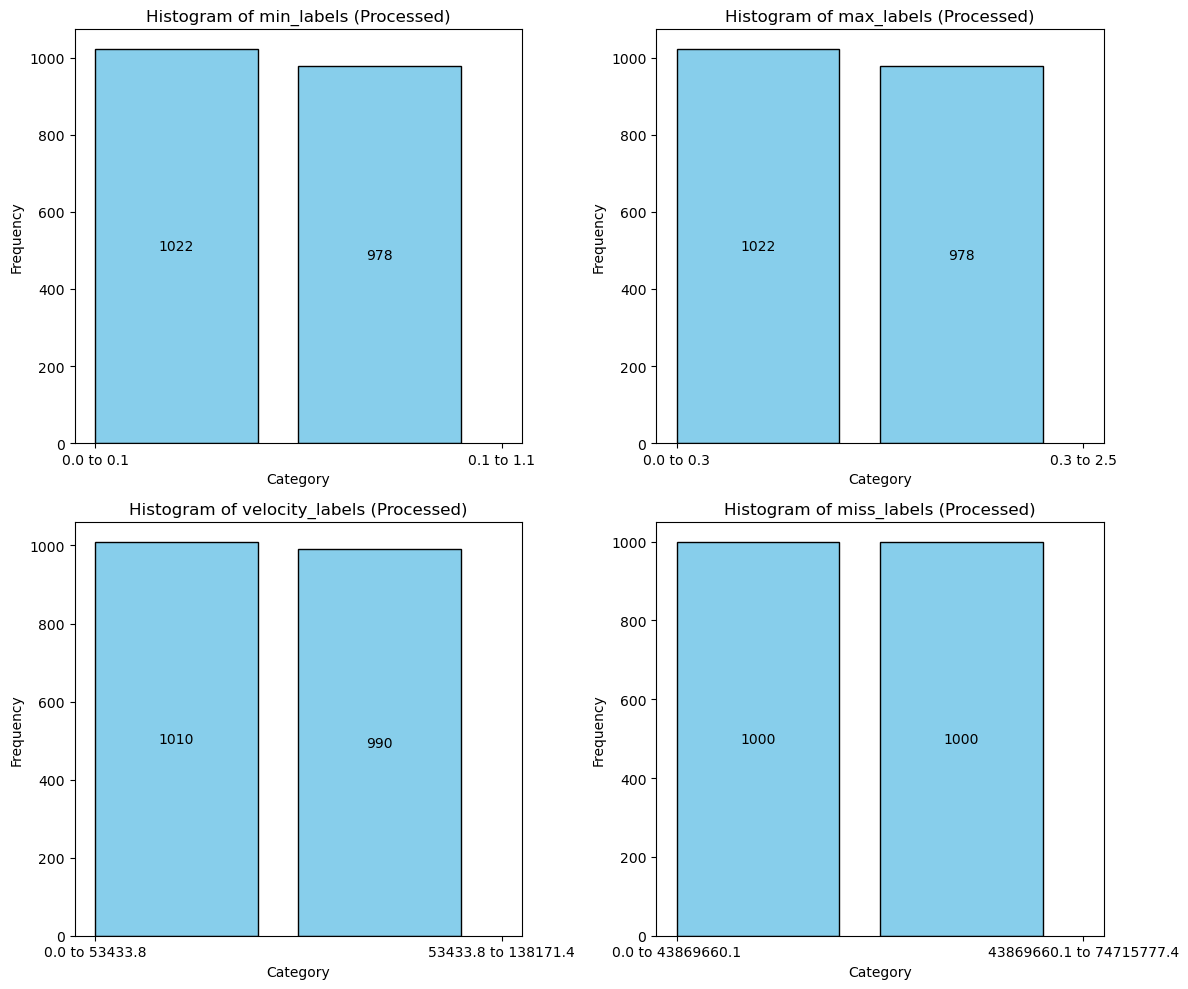

In [87]:
myutils.plot_multi_hist(discretized_label_dict,space_table.data)
# TODO: make this into grouped histograms (eg. Yes/No levels grouped by each bin of velocity_labels)

A decision tree fitted to this data returns this:

In [88]:
tree_classifier = MyDecisionTreeClassifier()
y_pred = myevaluation.cross_val_predict(tree_classifier,X_train,y_true,10)
print("\n", myevaluation.pseudo_classification_report(y_true,y_pred,labels))
 
header = space_table.column_names
print("Decision rules:")
tree_classifier.print_decision_rules(attribute_names=header)
tree_classifier.visualize_tree(
    "space_tree.dot", "space_tree", attribute_names=header
)


 Decision Tree Classifier: Accuracy = 0.74, Error Rate = 0.26, Precision = 0.7159, Recall = 0.8040, F1 Score = 0.7574
╒═════════════════╤════════╤═════════╕
│ Is Hazardous:   │   True │   False │
╞═════════════════╪════════╪═════════╡
│ True            │    804 │     196 │
├─────────────────┼────────┼─────────┤
│ False           │    319 │     681 │
╘═════════════════╧════════╧═════════╛
Decision rules:
IF estimated_diameter_min == 0 AND relative_velocity == 0 AND miss_distance == 0 THEN class = False.
IF estimated_diameter_min == 0 AND relative_velocity == 0 AND miss_distance == 1 THEN class = False.
IF estimated_diameter_min == 0 AND relative_velocity == 1 AND miss_distance == 0 THEN class = True.
IF estimated_diameter_min == 0 AND relative_velocity == 1 AND miss_distance == 1 THEN class = False.
IF estimated_diameter_min == 1 AND miss_distance == 0 AND relative_velocity == 0 THEN class = True.
IF estimated_diameter_min == 1 AND miss_distance == 0 AND relative_velocity == 1 THEN cla

To evaluate our Decision Trees' quality, we chose to focus on getting the highest Recall(?) because it is important to be able to predict a dangerous NEO as often as possible and a false negative would be devastating, while the consequences of a false alarm are not as tragic.